# Embedding a Recurrent Neural Network in an FMU

Created by [Michele Urbani](mailto:murbani@fbk.eu) on April 9th, 2025.

In [1]:
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


RAW_DATA_DIR = Path("heat-propagation-data")
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


## Simulating heat propagation in a squared plate

In [2]:
# Plate dimensions and simulation parameters
Lx, Ly = 10.0, 10.0   # Length and width of the plate
Nx, Ny = 50, 50       # Number of grid points in x and y directions
dx = Lx / Nx          # Spatial step size in x direction
dy = Ly / Ny          # Spatial step size in y direction
alpha = 0.9           # Thermal diffusivity
dt = 0.01             # Time step size
T = 25.0             # Total simulation time
T_impulse = T         # Duration of the heat impulse
T_ini = 0.0         # Initial temperature everywhere

# Staircase pulse parameters
num_steps = 5         # Number of steps in the staircase
max_temp = 200.0      # Maximum temperature during impulse
step_duration = T_impulse / num_steps  # Duration of each step

# Time-stepping parameters
Nt = int(T / dt)      # Number of time steps
Nt_impulse = int(T_impulse / dt)  # Number of steps for the impulse


In [5]:
# Function to compute the next time step using finite differences
def step(u, alpha, dx, dy, dt, n):
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u[n, i, j] = u[n - 1, i, j] + alpha * dt * (
                (u[n - 1, i + 1, j] - 2*u[n - 1, i, j] + u[n - 1, i - 1, j]) / dx**2 +
                (u[n - 1, i, j+1] - 2*u[n - 1, i, j] + u[n - 1, i, j-1]) / dy**2
            )

def run_simulation(alpha, u, T_ini, Nt, Nx, Ny, dt, dx, dy):
    """
    Parameters
    ----------
    alpha : float
        Thermal diffusivity of the plate.
    u : np.ndarray
        Temperature profile at each time step.
    T_ini : float
        Initial temperature of the plate.
    """
    # Initialize the temperature grid
    y = np.zeros((Nt, Nx, Ny))
    # Initial condition: zero everywhere
    y[0] = T_ini
    # Time-stepping loop
    for n in range(1, Nt):
        # Apply heat impulse on the left boundary (x = 0)
        y[n, :, 0] = u[n]
        # Update temperature across the plate
        step(y, alpha, dx, dy, dt, n)
    # Return only the temperature profile at the center of the plate
    return y[:, Nx//2, Ny//2]

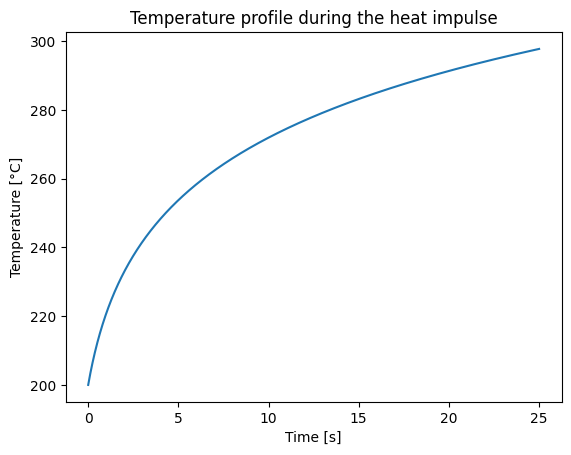

In [6]:
# Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 200.0
# Define a temperature profile for the heat impulse
u = 30 * np.log(t + 1) + T_ini
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

In [7]:
T_plate = 0.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

TypeError: run_simulation() missing 6 required positional arguments: 'Nt', 'Nx', 'Ny', 'dt', 'dx', and 'dy'

In [ ]:
# Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 100.0
# Define a temperature profile for the heat impulse
u = - 150 * np.sin(t / 4) + T_ini
df = pd.DataFrame(u, columns=["u"], index=t)
df.index.name = "time"
df.to_csv("input_signal.csv")
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

In [ ]:
T_plate = 100.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
df = pd.DataFrame(y, columns=["y"], index=t)
df.index.name = "time"
df.to_csv("true.csv")
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

## Generate data to train the model

Data are generate using only sine and cosine functions.

In [8]:
# Time duration
T = 50.0
# Time step size
dt = 0.01
Lx, Ly = 10.0, 10.0   # Length and width of the plate
Nx, Ny = 50, 50       # Number of grid points in x and y directions
dx = Lx / Nx          # Spatial step size in x direction
dy = Ly / Ny          # Spatial step size in y direction
# Number of time steps
Nt = int(T / dt)
# Time steps
t = np.linspace(0, T, Nt)
# Array to store the temperature profiles
U = []

alpha = 0.9

T_ini = 100.0
T_plate = 100.0

M = 50

# GENERATE SINUSOIDAL FUNCTIONALS
for i in range(M):
    u = (-1)**i * 20 * i * np.sin(t / 8 + i * np.pi / 8) + T_ini
    U.append({
        "alpha": alpha,
        "T_plate": T_plate,
        "u": u
    })

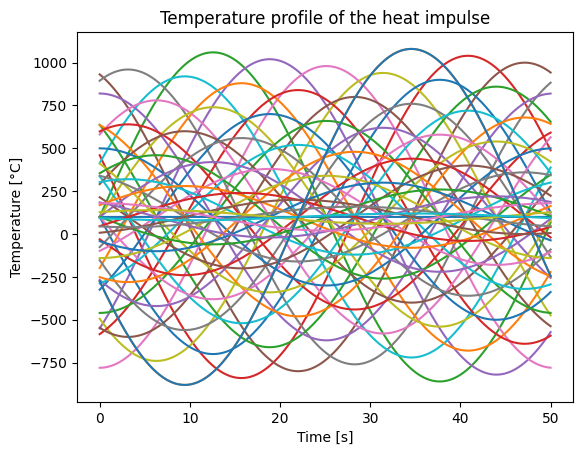

In [9]:
# Plot a temperature profile
for i in range(M):
    plt.plot(t, U[-i]["u"])
plt.plot(t, U[-1]["u"])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile of the heat impulse')
plt.show()

In [10]:
# Empty list to store the temperature profiles
Y = []
# Run the simulation for each temperature profile
for u in U:
    y = run_simulation(u["alpha"], u["u"], u["T_plate"], Nt, Nx, Ny, dt, dx, dy)
    Y.append(y)

In [11]:
# Include alpha and the initial plate temperature in the datasets
# Generate dataset for the parameters alpha and T_plate
X = []
for u in U:
    X.append([u["alpha"], u["T_plate"]])
params = pd.DataFrame(X, columns=["alpha", "T_plate"])
params.to_csv(RAW_DATA_DIR / "params.csv", index=False)

In [12]:
len(y)

5000

In [13]:
# Save input/output data
for i, y in enumerate(Y):
    data = pd.DataFrame({
        "time": t,
        "u": U[i]["u"],
        "y": y,
        "alpha": U[i]["alpha"] * np.ones_like(y),
        "T_plate": U[i]["T_plate"] * np.ones_like(y)
    })
    data.to_csv(RAW_DATA_DIR / f"case_{i}.csv", index=False)

## Train the RNN


### Create PyTorch datdaset

In [2]:
class HeatPropagationDataset(Dataset):

    def __init__(self, data: list, seq_length: int) -> None:
        X, Y = [], []
        for series in data:
            x = series[["u"]].values
            y = series["y"].values
            # Create sequences of input and output data
            for i in range(len(x) - seq_length):
                X.append(x[i:i+seq_length])
                Y.append(y[i+seq_length])

        # Convert to numpy arrays
        self.x = np.array(X).astype(np.float32)
        self.y = np.array(Y).astype(np.float32)

        # Save normalization parameters
        self.x_min = np.min(x).astype(np.float32)
        self.x_max = np.max(x).astype(np.float32)
        self.y_min = np.min(y).astype(np.float32)
        self.y_max = np.max(y).astype(np.float32)

        self.x = (self.x - self.x_min) / (self.x_max - self.x_min)
        self.y = (self.y - self.y_min) / (self.y_max - self.y_min)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Declare the RNN model

The RNN model is designed with ONNX's *statelessness* in mind. That is, no
internal state can be stored in the ONNX model because it can't be updated at
runtime, unless the FMU code is tweaked on purpose.

In [3]:
class HeatRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(HeatRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc1(x)
        return x[:, -1, :].squeeze(-1)

In [4]:
# Model parameters
seq_length = 200
hidden_size = 32
output_size = 1

test_model = HeatRNN(1, hidden_size, output_size)
print(test_model)
a = torch.randn(size=(1, seq_length, 1))
print(f"X shape {a.shape}")
test_model.eval()
b = test_model(a)
print(f"Y shape {b.shape}")

HeatRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)
X shape torch.Size([1, 200, 1])
Y shape torch.Size([1])


### Prepare for training...

In [5]:
EPOCHS = 500
BATCH_SIZE = 64
# Read data
data_files = sorted(RAW_DATA_DIR.glob("case_*.csv"))
data = []
for file in data_files:
    df = pd.read_csv(file)
    data.append(df)

data = data[:10]

seq_length = 200  # Number of time steps to look back

# Split files into training and testing datasets
train_size = int(0.8 * len(data))
test_size = int(0.2 * len(data))

random.seed(42)  # for reproducibility
torch.manual_seed(1234)
data_shuffled = random.sample(data, len(data))

train_data = data_shuffled[:train_size]
test_data = data_shuffled[train_size:]

train_dataset = HeatPropagationDataset(
    train_data,
    # data,
    seq_length)
test_dataset = HeatPropagationDataset(
    test_data,
    # data,
    seq_length)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

# Create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# initialize the hidden state
hidden = None

input_size = 1
hidden_size = 64
output_size = 1

model = HeatRNN(input_size, hidden_size, output_size)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Learning rate scheduler: Decays LR by gamma every step_size epochs
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.4)

### ... and train the RNN

In [6]:
# Set model train
train_loss = []
val_loss = []

# DEVICE SETUP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Outputs from the rnn
        prediction = model(x)
        # Calculate the loss
        loss = loss_fn(prediction, y)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Track loss
        running_loss += loss.item()
    # Log loss
    train_loss.append(running_loss / len(train_dataloader))
    # Calsulate validation loss
    model.eval()
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)
            running_loss += loss.item()
        val_loss.append(running_loss / len(val_dataloader))
    # Overwrite the previous message in Jupyter by printing with carriage return
    print(f"\rEpoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss[-1]:.8f}, "
          f"Val Loss: {val_loss[-1]:.8f}", end="")

    # Update learning scheduler
    # scheduler.step()

# Save the model
torch.save(model.state_dict(), "example3.pt")


Using device: cpu
Epoch [7/500], Train Loss: 0.07771350, Val Loss: 0.07521490

KeyboardInterrupt: 

In [7]:
print(x.shape)
print(prediction.shape)
print(y.shape)

torch.Size([256, 200, 1])
torch.Size([1, 200, 1])
torch.Size([256])


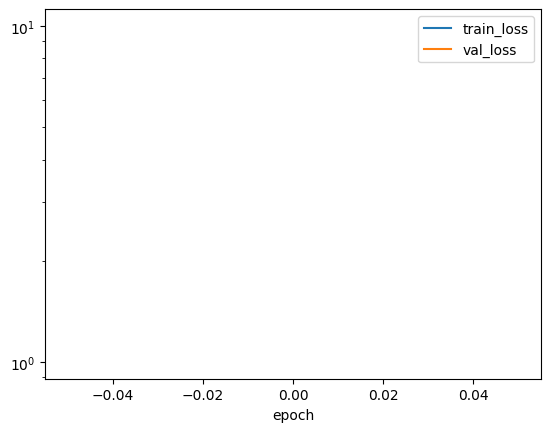

In [7]:
df_loss = pd.DataFrame({
    "train_loss": np.array([l for l in train_loss]),
    "val_loss": np.array([l for l in val_loss])
})
df_loss.index.name = "epoch"
df_loss. \
    iloc[20:]. \
    plot(
        logy=True
    )
df_loss.to_csv("loss.csv", index=True)

### Predictions

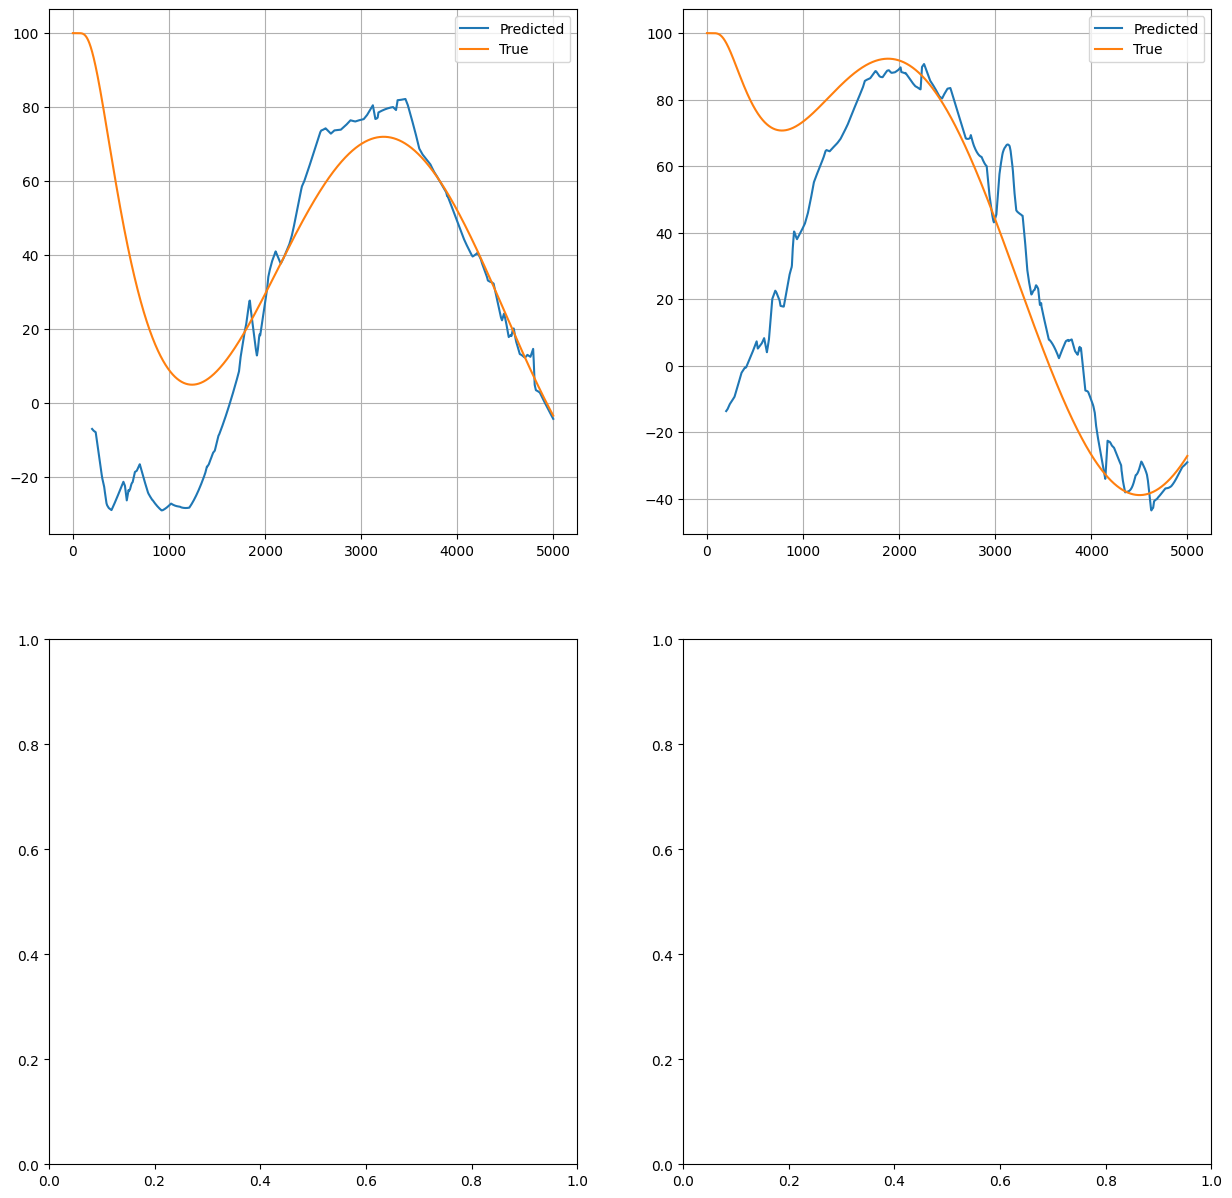

In [21]:
model.load_state_dict(torch.load("example3.pt"))
# Use the model to predict
model.eval()
# Select a test dataset for prediction
data = test_data

grid_axis = np.ceil(np.sqrt(len(test_data))).astype(int)

fig, axs = plt.subplots(grid_axis, grid_axis, figsize=(15, 15))

def predict(data: pd.DataFrame):

    predictions = []
    # Normalize the input data
    X = data['u'].values

    for i in range(len(X) - seq_length):
        # Cast to tensor
        x = torch.tensor(X[i:i + seq_length], dtype=torch.float32)
        # Normalize data
        x = (x - train_dataset.dataset.x_min) / (train_dataset.dataset.x_max - train_dataset.dataset.x_min)
        # Add batch dimension
        x = x.unsqueeze(0)
        # Outputs from the rnn
        with torch.no_grad():
            y = model(x.to(device))
        # Unnormalize prediction
        y = y * (train_dataset.dataset.y_max - train_dataset.dataset.y_min) + train_dataset.dataset.y_min
        # Remove batch dimension
        prediction = y.squeeze(0)
        # Append predictions to the list
        predictions.append(prediction.cpu().detach().numpy())

    # Concatenate all predictions
    return np.array(predictions)

for i, d in enumerate(test_data):
    predictions = predict(d)
    ax = axs[i // grid_axis, i % grid_axis]
    # Plot the predictions
    ax.plot(np.arange(seq_length, len(predictions) + seq_length), predictions)
    ax.plot(d['y'])
    # ax.set_xlabel("Time [ms]")
    # ax.set_ylabel("Temperature [°C]")
    ax.grid()
    ax.legend(["Predicted", "True"])
plt.show()

The RNN model works fine for demonstration purposes and we decide not to refine the model further.

## Export the model to ONNX

In [ ]:
# Export the model to the ONNX format
dummy_input = torch.randn(1, seq_length)

onnx_model_path = "example3.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    verbose=True,
    input_names=['input'],
    output_names=['output']
)


## Generate the FMU

In [ ]:
from onnx2fmu.app import build

build(
    model_path=onnx_model_path,
    model_description_path="example3Description.json",
    target_folder="temp"
)

In [ ]:
u = data['u'].values
# Save input to test the FMU
df = pd.DataFrame(
    [u[i:seq_length + i] for i in range(len(u) - seq_length)],
    columns=[f"input_0_{i}" for i in range(seq_length)]
)
df['time'] = np.arange(0, len(data['u'].values) / 2 - seq_length / 2, 0.5)
df.reset_index(inplace=True, drop=True)
df.set_index("time", inplace=True)
df.to_csv("input.csv", index=True)

for c in df.columns:
    df[c].to_csv(f"{c}.csv", index=True)

## Test the FMU using FMPy

In [ ]:
from fmpy import simulate_fmu, plot_result

input = np.genfromtxt("input.csv", delimiter=",", names=True)

results = simulate_fmu(
    "example3.fmu",
    start_time=0,
    stop_time=2500,
    input=input,
    output=["output_0_0"],
    validate=True,
    output_interval=0.5
)

plt.figure(figsize=(10, 5))
plt.plot(results["time"][:-seq_length] + 100, results["output_0_0"][:-seq_length], label="FMU prediction")
plt.plot(np.arange(0, 2500, 0.5), data['y'].values, label="True values")
plt.xlabel("Time [ms]")
plt.ylabel("Temperature [°C]")
plt.title("Temperature Prediction")
plt.grid()
plt.legend()
plt.show()

input_signal = pd.DataFrame({'time': np.arange(0, 25, 0.005), 'u': u}).to_csv('input_signal.csv', index=False)
true = pd.DataFrame({'time': np.arange(0, 25, 0.005), 'y': data['y'].values}).to_csv('true.csv', index=False)
predicted = pd.DataFrame(
    {'time': (results["time"][:-seq_length] + 100) / 100,
     'y': results["output_0_0"][:-seq_length]}
    ).to_csv('predicted.csv', index=False)